# Doom Playing Reinforcement Learning Model - Basic Level

## 1. Prepare Enviorment

In [70]:
# To install viz doom
# !pip install vizdoom

# Clone the VizDoom GitHub repo from this URL
# https://github.com/mwydmuch/ViZDoom

In [1]:
# Import necessary Libraries
import random # allows for action sampling
import time # # allows for sleeping between frames
import numpy as np # import for identity array matrix
from vizdoom import * # import for game enviornment
from matplotlib import pyplot as plt # import for vizualizations

In [18]:
game = DoomGame() # Define game
game.load_config('ViZDoom-master/ViZDoom-master/scenarios/defend_the_center.cfg') # Load Game configuration

# In Rendering options for defend_the_center.cfg -> change:
# Match res for basic.cfg
# Allows for faster training too
## screen_resolution = RES_320X240

game.init() # Initial Game 

In [19]:
# Set of possible actions in current Doom game enviornment
actions = np.identity(3, dtype=np.uint8)

#### Start new game episode

In [20]:
game.new_episode()

In [21]:
game.is_episode_finished()

False

In [22]:
game.get_state().screen_buffer.shape

(3, 240, 320)

In [23]:
state = game.get_state()

In [ ]:
# Loop to run through episodes (basic level) 
# Untrained - Random Actions

episodes = 10 # Play 10 games
for episode in range(episodes):
    game.new_episode() # Start from scratch
    while not game.is_episode_finished(): # Check if game is finished
        state = game.get_state() # Get current frame / game state
        img = state.screen_buffer # Get specific image
        info = state.game_variables # Get info on game state=
        # Take random action and assoicate that with reward 
        # Can add frame skip param to speed up 
        reward = game.make_action(random.choice(actions)) 
        print('Reward:', reward)
        time.sleep(0.002) # Take brief break before exiting while loop and printing game result
    print('Result:', game.get_total_reward())
    time.sleep(2) # Sleep 2 seconds before next iteration in for loop

In [24]:
game.close()

## 2. Convert game to OpenAI Gym enviornment

In [10]:
from gym import Env # Base class enviornment from OpenAI Gym
from gym.spaces import Discrete, Box # Allows us to define shapes from our enviornments
import cv2 # Allows for computer vision

#### Testing Box and Discrete

In [11]:
Box(low=0, high=10, shape=(10,10), dtype=np.uint8).sample()

array([[ 7,  6,  1,  2,  6, 10,  3,  3,  7,  3],
       [ 1,  8, 10,  9,  8,  6,  3,  2,  0,  0],
       [ 9,  5,  2,  2,  6,  9,  8,  5, 10,  0],
       [ 8,  1,  6,  9, 10,  6,  9,  0,  5,  2],
       [ 8,  6, 10,  6,  6,  6, 10,  1,  6,  3],
       [ 0,  7, 10,  6,  2,  4,  6,  6,  0,  3],
       [ 3,  4,  0,  5, 10,  5,  7,  3,  0,  7],
       [ 1,  7,  3,  7,  6,  3,  8,  3,  2,  3],
       [ 1,  3,  8,  1,  0,  4,  5,  1,  9,  6],
       [ 2,  0,  5,  7,  2,  9,  2,  8,  3,  2]], dtype=uint8)

In [12]:
Discrete(3).sample()

2

In [13]:
actions[Discrete(3).sample()]

array([0, 1, 0], dtype=uint8)

#### Define vizDoom Enviornment Class

In [25]:
class VizDoomGym(Env):
    
    # Function called at initialization(start) of Env
    def __init__(self, render=False):
        # Inherit from Env
        super().__init__()
        # Set up game
        self.game = DoomGame() # Define game
        # Load Game configuration; able to change
        self.game.load_config('ViZDoom-master/ViZDoom-master/scenarios/defend_the_center.cfg') 
        
        # Define whether or not to render the game - Rendering hinders training speed
        # Render frame logic
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        
        # Initial Game (Start Game)
        self.game.init() 
        
        # Create and define observation and activation space for game
        self.observation_space = Box(low=0, high=255, shape=(100,160,1), dtype=np.uint8)
        self.action_space = Discrete(3)
    
    # Function - how we take steps in enviornment
    def step(self, action):
        # Specify action and take step
        actions = np.identity(3, dtype=np.uint8) # Define actions
        reward = self.game.make_action(actions[action], 4) # Define reward based on action
        
        # Get and return relevent game information, variables
        if self.game.get_state(): 
            state = self.game.get_state().screen_buffer # Define current game state
            state = self.grayscale(state) # Apply gray scale to step function
            ammo = self.game.get_state().game_variables[0] # Return ammo game variables
            info = ammo
        else:
            state = np.zeros(self.observation_space.shape)
            info = 0
        
        info = {"info":info}
        done = self.game.is_episode_finished() # Determine whether game is finsihed
        
        return state, reward, done, info
    
    # Don't need to define render function - predefined in vizDoom
    # Normally, the function to render a game / enviornment
    def render():
        pass
    
    # Function - what happens when new game is started
    def reset(self):
        self.game.new_episode() # Start new game
        state = self.game.get_state().screen_buffer
        return self.grayscale(state) # Apply grayscale to reset function
    
    # Function - grayscale and resize game frame
    def grayscale(self, observation):
        # Concert to grayscale
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        # Resize to remove bottom info bar from game observation
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state
     
    # Function - Call to close down game
    def close(self):
        self.game.close()

#### Test enviornment and return relevant information

In [34]:
env = VizDoomGym(render=False)

In [35]:
env.observation_space.sample().shape

(100, 160, 1)

In [36]:
env.action_space

Discrete(3)

## 3. View State

In [37]:
state = env.reset()

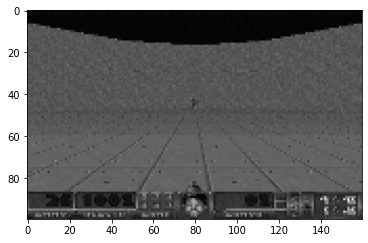

In [38]:
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

In [40]:
env.close()

In [32]:
# Import enviornment checker
from stable_baselines3.common import env_checker

In [39]:
# Check for valid env - no error is good
env_checker.check_env(env)

## 4. Setup Callback

In [41]:
# import necessary libraries
import os
from stable_baselines3.common.callbacks import BaseCallback

In [42]:
# Define class for training and logging callback
class TrainAndLoggingCallback(BaseCallback):
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
            
        return True

In [43]:
# Dirs for saving trained RL models
CHECKPOINT_DIR = './train/train_defend_the_center'
LOG_DIR = './logs/log_defend_the_center'

In [44]:
# Create instance of train and logging callback - save pytorch model every 10,000 steps
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

## 5. Train Reinforcement Learning Model

In [45]:
# Import ppo for training
from stable_baselines3 import PPO

In [46]:
# Create non rendered enviornment
env = VizDoomGym()

In [47]:
# Define model and policy 
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=4096)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [48]:
# Train model
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/log_defend_the_center\PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 82       |
|    ep_rew_mean     | 0.286    |
| time/              |          |
|    fps             | 46       |
|    iterations      | 1        |
|    time_elapsed    | 89       |
|    total_timesteps | 4096     |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 87.1      |
|    ep_rew_mean          | 0.645     |
| time/                   |           |
|    fps                  | 37        |
|    iterations           | 2         |
|    time_elapsed         | 219       |
|    total_timesteps      | 8192      |
| train/                  |           |
|    approx_kl            | 0.0113112 |
|    clip_fraction        | 0.116     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.09     |
|    explained_variance   | -0.016    |
|    learning_

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 133         |
|    ep_rew_mean          | 5.63        |
| time/                   |             |
|    fps                  | 33          |
|    iterations           | 11          |
|    time_elapsed         | 1336        |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.022124935 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.8        |
|    explained_variance   | 0.819       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0076     |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0411     |
|    value_loss           | 0.176       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 140   

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 188        |
|    ep_rew_mean          | 9.77       |
| time/                   |            |
|    fps                  | 33         |
|    iterations           | 21         |
|    time_elapsed         | 2567       |
|    total_timesteps      | 86016      |
| train/                  |            |
|    approx_kl            | 0.03255917 |
|    clip_fraction        | 0.226      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.546     |
|    explained_variance   | 0.937      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0112    |
|    n_updates            | 200        |
|    policy_gradient_loss | -0.0399    |
|    value_loss           | 0.121      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 194         |
|    ep_rew_m

## 6. Test Model

In [60]:
# import evaluation policy to test agent
from stable_baselines3.common.evaluation import evaluate_policy
import time

In [61]:
# Reload model from disc drive
model = PPO.load('./train/train_defend_the_center/best_model_100000')

In [62]:
# Create rendered enviornment
env = VizDoomGym(render=True)

In [56]:
# Evaluate mean reward for 10 games
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)

In [57]:
# Display mean reward
mean_reward

12.0

In [63]:
# Loop to test agent without using evaluate_policy
for episode in range(10): 
    obs = env.reset() # observations
    done = False # havent completed
    total_reward = 0 
    while not done: 
        action, _ = model.predict(obs) # get action
        obs, reward, done, info = env.step(action) # pass into env step function
        #time.sleep(0.20)
        total_reward += reward # update reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))

Total Reward for episode 0 is 12.0
Total Reward for episode 1 is 13.0
Total Reward for episode 2 is 14.0
Total Reward for episode 3 is 11.0
Total Reward for episode 4 is 11.0
Total Reward for episode 5 is 12.0
Total Reward for episode 6 is 11.0
Total Reward for episode 7 is 11.0
Total Reward for episode 8 is 13.0
Total Reward for episode 9 is 9.0


In [64]:
env.close()